Import packages and include helper functions for the unscented Kalman filter. The UKF code is inspired by the code in [Chapter 19](/https://algorithmsbook.com/files/chapter-19.pdf) of *Kochenderfer, M. J., 
Wheeler, T. A., & Wray, K. H. (2022). Algorithms for Decision Making. MIT Press.*

In [1]:
using Distributions
using LinearAlgebra
using PGFPlots
using Random
using StatsBase

include("ukf.jl")

update (generic function with 1 method)

In this example we test the UPF on a synthetic scalar estimation problem. The problem is based on the scalar estimation task presented in [*Van Der Merwe, R., Doucet, A., De Freitas, N., & Wan, E. (2000). The Unscented Particle Filter. Advances in Neural Information Processing Systems, 13.*](\https://proceedings.neurips.cc/paper/2000/hash/f5c3dd7514bf620a1b85450d2ae374b1-Abstract.html).

The noise-free time series is generated by the following process model:

\begin{align*}
    x_{t+1} &= 1 + \sin(\omega \pi t) + \phi_1 x_t
\end{align*}

where $\omega = 4e -2$ and $\phi_1$ is a scalar. The measurement model is non-stationary:

\begin{align*}
y_t &= 
    \begin{cases}
		\phi_2 x_t^2 & t \leq 30\\
        \phi_3 x_t - 2 & t > 30
    \end{cases}
\end{align*}

where $\phi_2$ and $\phi_3$ are scalars.

In [2]:
# Transition model
function f(x, t)
    ϕ1 = 0.5
    ω = 4*exp(1) - 2
    x′ = 1 + sin(ω*π*t) + ϕ1*x

    return x′
end

# Measurement model
function h(x, t)
    ϕ2 = 0.2; ϕ3 = 0.5
    if t <= 30
        y = ϕ2*x^2;
    else
        y = ϕ3*x - 2;
    end
    return y
end

# Function to run T steps of a simulation starting at state x0 and using the
# transition model f and measurement model h specified by the filter
function simulate(upf, x0, T, times)   
    Q, R, f, h = upf.Q, upf.R, upf.f, upf.h
    states =[x0]; observations = [NaN]
    for t = 2:T
        push!(states, 
            f(states[t-1], times[t]) + rand(Normal(0.0, sqrt(Q))))
        push!(observations, 
            h(states[t], times[t]) + rand(Normal(0.0, sqrt(R))))
    end
    return states, observations
end

simulate (generic function with 1 method)

Initialize simulation variables:

In [3]:
T   = 60            # Simulation length
N   = 50            # Number of particles
Δt  = 1             # Time step
times = 0:Δt:T      # Simulation times

# Noise statistics
Q   = 1.0
R   = 0.001

ukf = UnscentedKalmanFilter(2, Q, R, f, h) # Unscented kalman filter

x0  = 1.0
x   = fill(x0, N)   # Initial particle set values
P0  = 0.75
P   = fill(P0, N)   # Initial particle set covariances

x̂   = fill(x0, N)   # Data structure to hold sampled particles
x̄   = fill(x0, N)   # Data structure to hold posterior means
P̂   = fill(P0, N)   # Data structure to hold posterior covariances

μ_data  = [mean(x)] # Vector to hold mean data for plotting
Σ_data  = [cov(x)]  # Vector to hold covariance data for plotting

# Generate simulated data
states, observations = simulate(ukf, x0, lastindex(times), times);

Run the unscented particle filter:

In [4]:
for t = 2:lastindex(times)
    Q, R = ukf.Q, ukf.R # Noise statistics
    y = observations[t] # Latest observation     
    for i = 1:N
        # Perform a belief update
        x̄[i], P̂[i] = update(ukf, x[i], P[i], y, times[t])
        # Draw a new particle from the proposal distribution
        x̂[i] = rand(Normal(x̄[i], sqrt(P̂[i])))
    end

    # Evaluate importance weights up to a normalizing constant
    w = ones(N)/N;
    for i = 1:N
        ŷ = h(x̂[i], times[t])  # Predicted measurement

        # Compute observation likelihood
        likelihood = pdf(Normal(ŷ, sqrt(R)), y)
        # Calculate prior
        prior = pdf(Normal(x[i], sqrt(Q)), x̂[i])
        # Calculate proposal
        proposal = pdf(Normal(x̄[i], sqrt(P̂[i])), x̂[i])
        
        # Compute the particle weight
        w[i] = likelihood * prior / proposal
    end
    # Normalize weights
    w = w/sum(w)

    # Resample particles
    resampled_idx = sample(1:N, Weights(w), N, replace=true)
    x = x̂[resampled_idx]
    P = P[resampled_idx]

    # Store plotting data
    push!(μ_data, mean(x)); push!(Σ_data, cov(x))
end

Plot the resulting estimate of the true state:

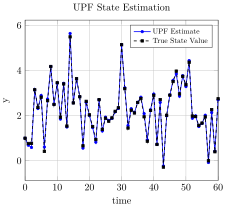

In [5]:
p = Axis([
    Plots.Linear(times, μ_data, legendentry="UPF Estimate",
        style="blue, thick, mark options={scale=0.6, fill=blue, solid}"), 
    Plots.Linear(times, states, legendentry="True State Value",
        style=style="black, dashed, thick, mark options={scale=0.6,fill=black, solid}"),
],
style="enlarge x limits=false,grid=both", ylabel="y", xlabel="time",
title="UPF State Estimation", legendPos="north east",
legendStyle="nodes = {scale = 0.75}")